# Starbucks Capstone Challenge

## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

This data set contains three files. The first file describes the characteristics of each offer, including its duration and the amount a customer needs to spend to complete it (difficulty). The second file contains customer demographic data including their age, gender, income, and when they created an account on the Starbucks rewards mobile application. The third file describes customer purchases and when they received, viewed, and completed an offer. An offer is only successful when a customer both views an offer and meets or exceeds its difficulty within the offer's duration.

## Problem Statement / Metrics

The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has two steps. First, I will combine the offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. Second, I will assess the accuracy and F1-score of a naive model that assumes all offers were successful. This provides me with a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful. However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. For this situation, evaluating a models' precision and recall provides better insight into its performance. I chose the F1-score metric because it is "a weighted average of the precision and recall metrics".

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import re
import math
import json
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

% matplotlib inline

### Import Datasets

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Portfolio Data

### Portfolio Data Overview

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.difficulty.unique()

array([10,  0,  5, 20,  7])

In [6]:
portfolio.duration.unique()

array([ 7,  5,  4, 10,  3])

In [7]:
portfolio.reward.unique()

array([10,  0,  5,  3,  2])

In [8]:
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

### Cleaning Portfolio Data

- rename id column name to offer_id
- one-hot encoding of channels column
- one-hot encoding of offer_type column

In [9]:
# rename id col name to offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [10]:
# one-hot encode channels

for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
portfolio.drop(columns='channels', inplace=True)

In [11]:
# one-hot encode offer_type column

for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if offertype in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0
portfolio.drop(columns='offer_type', inplace=True)

In [12]:
# Check for Duplicates
portfolio.duplicated().sum()

0

In [13]:
portfolio

,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1.0,1.0,0.0,1.0,0.0,0.0,1.0


# Profile Data

### Profile Data Overview

In [14]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [16]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

### Cleaning Profile Data

- rename id column name to customer_id.
- change age value 118 to nan.
- create readable date format in became_member_on column.
- drop rows with no gender, income, age data
- convert gender values to numeric 0s and 1s
- add start year and start month columns (for further analysis)

In [17]:
# profile: rename id col name customer_id.
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [18]:
profile.where(profile.age==118).count()

age                 2175
became_member_on    2175
gender                 0
customer_id         2175
income                 0
dtype: int64

In [19]:
# profile: change age value 118 to nan.
profile.age.replace(118, np.nan, inplace=True)

In [20]:
# profile: create readable date format for became_member_on column.
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")

In [21]:
len(profile[profile['gender'].isnull()].index)

2175

In [22]:
# profile: drop rows with no gender, income, age data
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [23]:
# Convert gender values to numeric 0s and 1s
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [24]:
# profile: add start_year column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month

In [25]:
profile

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11
13,61.0,2017-09-11,0,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017,9
14,26.0,2014-02-13,1,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014,2
15,62.0,2016-02-11,0,31dda685af34476cad5bc968bdb01c53,71000.0,2016,2
16,49.0,2014-11-13,1,62cf5e10845442329191fc246e7bcea3,52000.0,2014,11
18,57.0,2017-12-31,1,6445de3b47274c759400cd68131d91b4,42000.0,2017,12


# Transcript Data

### Transcript Data Overview

In [26]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [27]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [28]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Cleaning Transcript Data

- rename person column name to customer_id.
- create separate columns for amount and offer_id from value column.
- drop transaction rows whose customer_id is not in profile:customer_id
- convert time in hours to time in days
- segregate offer and transaction data 
- finally drop duplicates if any

In [29]:
# transcript: rename person col name to customer_id.
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [30]:

# transcript: create separate columns for amount and offer_id from value col.

def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# change amount column type to float
transcript.amount.astype('float')

# drop value column
transcript.drop(columns=['value'], inplace=True)

In [31]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [32]:
transcript['time'] /= 24.0

In [33]:
# access the duplicate values
transcript.duplicated().sum()

374

In [34]:
# drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)

In [35]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 5 columns):
event          272388 non-null object
customer_id    272388 non-null object
time           272388 non-null float64
offer_id       148431 non-null object
amount         123957 non-null float64
dtypes: float64(2), object(3)
memory usage: 10.4+ MB


In [36]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [37]:
# transcript:  segregate offer and transaction data 

# extract transactions from transcript data
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11032,54890f68699049c2a04d415abc25e717,0.00,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
11047,629fc02d56414d91bca360decdfa9288,0.00,33.90
11051,a97e6f33219c432db82acfa0d19c602d,0.00,18.59
11055,676506bad68e4161b9bbaffeb039626b,0.00,18.01
11059,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.00,19.11
11069,4cbe33c601a5407f8202086565c55111,0.00,36.19


In [38]:
# transcript:  seggregate offer and transaction data 

# extract offer-related from transcript data
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [39]:
transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [40]:
offers_df.viewed.sum(), offers_df.completed.sum(), offers_df.received.sum()

(49860, 32070, 66501)

In [41]:
offers_df

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
5,31dda685af34476cad5bc968bdb01c53,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
6,4b0da7e80e5945209a1fdddfe813dbe0,0.00,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
7,c27e0d6ab72c455a8bb66d980963de60,0.00,3f207df678b143eea3cee63160fa8bed,1,0,0
8,d53717f5400c4e84affdaeda9dd926b3,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
9,f806632c011441378d4646567f357a21,0.00,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


## Exploratory Data Analysis

### 1. Profile data

In [42]:
profile

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11
13,61.0,2017-09-11,0,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017,9
14,26.0,2014-02-13,1,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014,2
15,62.0,2016-02-11,0,31dda685af34476cad5bc968bdb01c53,71000.0,2016,2
16,49.0,2014-11-13,1,62cf5e10845442329191fc246e7bcea3,52000.0,2014,11
18,57.0,2017-12-31,1,6445de3b47274c759400cd68131d91b4,42000.0,2017,12


#### Check for any missing values in each column

In [43]:
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
customer_id         0
income              0
start_year          0
start_month         0
dtype: int64

#### Compute gender distribution in customer's data

In [44]:
profile.gender.value_counts()

1    8484
0    6341
Name: gender, dtype: int64

#### Stats of customer age and income attributes when income is specified

In [45]:
profile[profile['income'].notnull()].describe()

,age,gender,income,start_year,start_month
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,0.572277,65404.991568,2016.620169,6.695582
std,17.383705,0.494765,21598.299410,1.198245,3.488853
min,18.000000,0.000000,30000.000000,2013.000000,1.000000
25%,42.000000,0.000000,49000.000000,2016.000000,4.000000
50%,55.000000,1.000000,64000.000000,2017.000000,7.000000
75%,66.000000,1.000000,80000.000000,2017.000000,10.000000
max,101.000000,1.000000,120000.000000,2018.000000,12.000000


#### Compute what percent of customers vs which year enrolled as a member

In [46]:
year_count = profile['start_year'].value_counts()

year_count *= 100 / year_count.sum()
year_count

2017    37.767285
2018    24.748735
2016    20.397976
2015    10.772344
2014     4.465430
2013     1.848229
Name: start_year, dtype: float64

#### Compute what percent of customers vs which month enrolled as a member

In [47]:
month_count = profile['became_member_on'].apply(lambda date: date.month).value_counts()

month_count *= 100 / year_count.sum()
month_count.sort_index()

1     1327.0
2     1042.0
3     1145.0
4     1145.0
5     1152.0
6     1105.0
7     1189.0
8     1395.0
9     1299.0
10    1386.0
11    1268.0
12    1372.0
Name: became_member_on, dtype: float64

# Data Visualisation

#### Profile General Distribution — Age, Income, Members

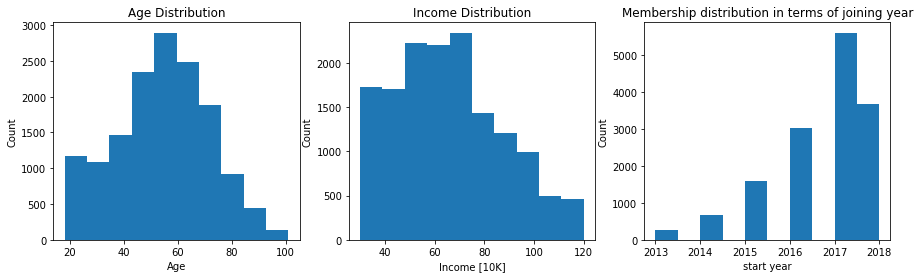

In [48]:
# to be able to draw three subplots in a row
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)

# plot a age distribution in data
plt.sca(ax[0])
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

# plot a income distribution in data
plt.sca(ax[1])
plt.hist(profile['income'] * 1E-3 )
plt.xlabel('Income [10K]')
plt.ylabel('Count')
plt.title('Income Distribution');

# plot a start_year distribution
plt.sca(ax[2])
plt.hist(profile['start_year'])
plt.xlabel('start year')
plt.ylabel('Count')
plt.title('Membership distribution in terms of joining year');

Age distribution plot depicts that the median age of a customer is 60 and most of our customers belong to age range between 40 to 70. Income distribution plot shows that the number of customers whose average salary is less than 70K is high than the other side considering 70K to be median of the income distribution. Membership distribution has interesting results - 2017 has the highest registered customers than any starting from 2013. The plot also shows that there is an increasing trend in the number of registrations except for 2017

#### Income distribution as a function a gender

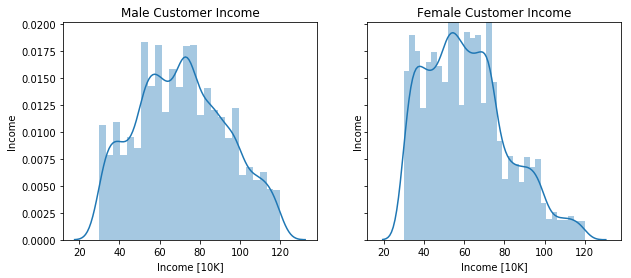

In [49]:
# extract male and female customers
male_customers = profile[profile['gender'] == 0]
female_customers = profile[profile['gender'] == 1]

# to be able to draw two subplots in a row
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(male_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Male Customer Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(female_customers['income'] * 1E-3)
plt.xlabel('Income [10K]')
plt.ylabel('Income')
plt.title('Female Customer Income');

- plots conclude that minimum and maximum income for both male and female are approximately same but the count of male customers in low-income level is slightly higher than that of female customers

#### Age distribution as a function of gender

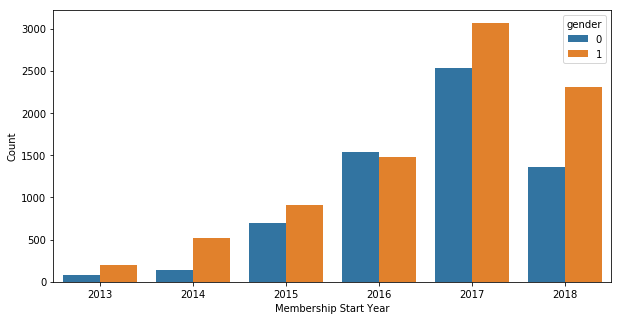

In [50]:
# groupby start_year and gender to plot a graph
membership_date = profile.groupby(['start_year', 'gender']).size()
membership_date = membership_date.reset_index()
membership_date.columns = ['start_year', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender in membership program
plt.figure(figsize=(10, 5))
sns.barplot(x='start_year', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count');

The results suggest that most customers joined the Starbucks rewards program in 2017 followed by 2018. Plots also depict that there are more male customers joining the program every year.

### 2. Transaction data 

#### Compute the event type distribution

In [51]:
event_counts = transcript['event'].value_counts()
event_counts

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [52]:
total_transactions = event_counts.sum()

transactions_perc = 100 * event_counts[0] / total_transactions
offers_perc = 100 * event_counts[1:].sum() / total_transactions

(transactions_perc, offers_perc)

(45.507511344112075, 54.492488655887925)

In [53]:
profile

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11
13,61.0,2017-09-11,0,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017,9
14,26.0,2014-02-13,1,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014,2
15,62.0,2016-02-11,0,31dda685af34476cad5bc968bdb01c53,71000.0,2016,2
16,49.0,2014-11-13,1,62cf5e10845442329191fc246e7bcea3,52000.0,2014,11
18,57.0,2017-12-31,1,6445de3b47274c759400cd68131d91b4,42000.0,2017,12


In [54]:
portfolio

,difficulty,duration,offer_id,reward,web,email,social,mobile,bogo,informational,discount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1.0,1.0,0.0,0.0,0.0,0.0,1.0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1.0,1.0,1.0,1.0,0.0,0.0,1.0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [55]:
offers_df

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
5,31dda685af34476cad5bc968bdb01c53,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
6,4b0da7e80e5945209a1fdddfe813dbe0,0.00,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
7,c27e0d6ab72c455a8bb66d980963de60,0.00,3f207df678b143eea3cee63160fa8bed,1,0,0
8,d53717f5400c4e84affdaeda9dd926b3,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
9,f806632c011441378d4646567f357a21,0.00,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


In [56]:
transaction_df

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11032,54890f68699049c2a04d415abc25e717,0.00,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
11047,629fc02d56414d91bca360decdfa9288,0.00,33.90
11051,a97e6f33219c432db82acfa0d19c602d,0.00,18.59
11055,676506bad68e4161b9bbaffeb039626b,0.00,18.01
11059,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.00,19.11
11069,4cbe33c601a5407f8202086565c55111,0.00,36.19


In [57]:
# Credits to https://github.com/kuk/log-progress
# Used for Progress Bar

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Data Preprocessing

In [58]:
def merge_data(profile, portfolio, offers_df, transaction_df):
    data = []
    ids_customers = offers_df['customer_id'].unique()
        
    # Looping through all the Customer IDs in offers_df
    for i in log_progress(range(len(ids_customers)), every=1):
        
        # Get customer ID from list
        id_cust = ids_customers[i]
        
        # Extracting the customer profile from profile data
        customer = profile[profile['customer_id']== id_cust]
        
        # Extract offers linked with the customer from offers_df
        offer_cust_data = offers_df[offers_df['customer_id']== id_cust]
        
        # extract transactions associated with the customer from transactions_df
        transaction_cust_data = transaction_df[transaction_df['customer_id']== id_cust]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received = offer_cust_data[offer_cust_data['received'] == 1]
        offer_completed = offer_cust_data[offer_cust_data['completed'] == 1]
        offer_viewed = offer_cust_data[offer_cust_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed['time'] >= start_time, offer_completed['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed['time'] >= start_time, offer_viewed['time'] <= end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                transaction_cust_data['time'] >= start_time, transaction_cust_data['time'] <= end_time)
        
            transaction_data = transaction_cust_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': id_cust,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [59]:
data = merge_data(profile, portfolio, offers_df, transaction_df)
# It will take 10-15 minutes to complete, however the data is saved 

VBox(children=(HTML(value=''), IntProgress(value=0, max=14820)))

In [60]:
data.offer_successful.value_counts()

0    35136
1    31365
Name: offer_successful, dtype: int64

In [61]:
columns_list = ['time', 'offer_id', 'customer_id', 'total_amount', 
                'offer_successful', 'difficulty', 'duration', 
                'reward', 'bogo', 'discount', 'informational',
                'email', 'mobile', 'social', 'web', 'became_member_on',
                'gender', 'income', 'age', 'start_year', 'start_month']
data[columns_list]

,time,offer_id,customer_id,total_amount,offer_successful,difficulty,duration,reward,bogo,discount,...,email,mobile,social,web,became_member_on,gender,income,age,start_year,start_month
0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,37.67,1,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2017-05-09,0,100000.0,75.0,2017,5
1,7.0,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,49.39,0,0,3,0,0.0,0.0,...,1.0,1.0,1.0,0.0,2017-05-09,0,100000.0,75.0,2017,5
2,17.0,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,10,7,10,1.0,0.0,...,1.0,1.0,1.0,0.0,2017-05-09,0,100000.0,75.0,2017,5
3,21.0,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,48.28,1,5,5,5,1.0,0.0,...,1.0,1.0,1.0,1.0,2017-05-09,0,100000.0,75.0,2017,5
4,0.0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.00,0,10,7,2,0.0,1.0,...,1.0,1.0,0.0,1.0,2018-04-26,1,70000.0,68.0,2018,4
5,14.0,3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,0.00,0,0,4,0,0.0,0.0,...,1.0,1.0,0.0,1.0,2018-04-26,1,70000.0,68.0,2018,4
6,17.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,18.42,1,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2018-04-26,1,70000.0,68.0,2018,4
7,21.0,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,18.42,1,10,10,2,0.0,1.0,...,1.0,1.0,1.0,1.0,2018-04-26,1,70000.0,68.0,2018,4
8,0.0,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,9.54,1,5,5,5,1.0,0.0,...,1.0,1.0,1.0,1.0,2018-02-09,1,53000.0,65.0,2018,2
9,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,0.00,0,5,7,5,1.0,0.0,...,1.0,1.0,0.0,1.0,2018-02-09,1,53000.0,65.0,2018,2


In [62]:
data.to_csv('master_offer_analysis.csv', index=False)

In [63]:
data = pd.read_csv('master_offer_analysis.csv')

In [64]:
column_ordering = ['offer_id', 'total_amount']
column_ordering.extend([elem for elem in data.columns if elem not in column_ordering])

data = data[column_ordering]
data = data.drop(columns=['time', 'customer_id', 'email', 'informational', 'became_member_on'])
data.head()

,offer_id,total_amount,age,bogo,difficulty,discount,duration,gender,income,mobile,offer_successful,reward,social,start_month,start_year,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,75.0,1.0,5,0.0,7,0,100000.0,1.0,1,5,0.0,5,2017,1.0
1,5a8bc65990b245e5a138643cd4eb9837,49.39,75.0,0.0,0,0.0,3,0,100000.0,1.0,0,0,1.0,5,2017,0.0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,75.0,1.0,10,0.0,7,0,100000.0,1.0,1,10,1.0,5,2017,0.0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,75.0,1.0,5,0.0,5,0,100000.0,1.0,1,5,1.0,5,2017,1.0
4,2906b810c7d4411798c6938adc9daaa5,0.00,68.0,0.0,10,1.0,7,1,70000.0,1.0,0,2,0.0,4,2018,1.0


In [65]:
def calculate_percentage_success():
    successful_count = data[['offer_id', 'offer_successful']].groupby(
        'offer_id').sum().reset_index()

    offer_count = data['offer_id'].value_counts()

    offer_count = pd.DataFrame(list(zip(offer_count.index.values,
                                        offer_count.values)),
                               columns=['offer_id', 'count'])

    successful_count = successful_count.sort_values('offer_id')

    offer_count = offer_count.sort_values('offer_id')

    percent_success = pd.merge(offer_count, successful_count, on="offer_id")

    percent_success['percent_success'] = (
        100 * percent_success['offer_successful'] / percent_success['count'])

    percent_success = pd.merge(percent_success, portfolio, on="offer_id")

    percent_success = percent_success.drop(columns=['offer_successful'])

    percent_success = percent_success.sort_values('percent_success', ascending=False)

    return percent_success.reset_index(drop=True)

In [66]:
percent_success = calculate_percentage_success()
percent_success

,offer_id,count,percent_success,difficulty,duration,reward,web,email,social,mobile,bogo,informational,discount
0,fafdcd668e3743c1bb461111dcafc2a4,6652,75.285628,10,10,2,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,72.742299,7,7,3,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,f19421c1d4aa40978ebb69ca19b0e20d,6576,61.618005,5,5,5,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,ae264e3637204a6fb9bb56bc8210ddfd,6683,54.646117,10,7,10,0.0,1.0,1.0,1.0,1.0,0.0,0.0
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,51.721523,10,5,10,1.0,1.0,1.0,1.0,1.0,0.0,0.0
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,48.287210,5,7,5,1.0,1.0,0.0,1.0,1.0,0.0,0.0
6,2906b810c7d4411798c6938adc9daaa5,6631,47.730357,10,7,2,1.0,1.0,0.0,1.0,0.0,0.0,1.0
7,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,45.762712,20,10,5,1.0,1.0,0.0,0.0,0.0,0.0,1.0
8,3f207df678b143eea3cee63160fa8bed,6657,7.721196,0,4,0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
9,5a8bc65990b245e5a138643cd4eb9837,6643,6.277284,0,3,0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


### Generate a plot that illustrates:

- How many customers were provided with a specific offer?
- Offer success rate (percentsuccess)

Text(0,0.5,'Success percentage')

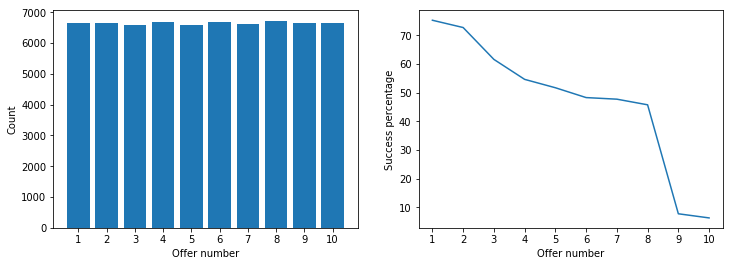

In [67]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

ax[0].bar(percent_success.index + 1, percent_success['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer number')
ax[0].set_ylabel('Count')

ax[1].plot(percent_success.index + 1, percent_success['percent_success'])
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer number')
ax[1].set_ylabel('Success percentage')

### Label Encoding the Object type columns in the Data

In [68]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

X=data

for i in range(0,X.shape[1]):
    if X.dtypes[i]=='object':
        X[X.columns[i]]=le.fit_transform(X[X.columns[i]])

# Create train and test data sets 

In [69]:
# factors/features that influence the label variable
X = data.drop(columns=['offer_successful'])

# label variable to predict
y = data.filter(['offer_successful'])

In [70]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [71]:
# convert train and test labels to array
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Implementation of various Algorithmns

In [72]:
def model_evaluation(model, X_test, y_test):
    #predict on Test Data
    prediction = model.predict(X_test)
    
    # import the metrics
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
    
    # Calculate the Metrics
    accuracy = accuracy_score(y_test, prediction)
    f1_score = f1_score(y_test, prediction)
    
    
    print("Model Accuracy: {}".format(np.round(accuracy,6)))
    print("Model F1-Score: {}".format(np.round(f1_score,6)))
    print("------------------------------------------------")
    print("Confusion Matrix: \n {}".format(confusion_matrix(y_test, prediction)))
    print("------------------------------------------------")
    print(classification_report(y_test, prediction))
    


# ADA Boost

In [73]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [74]:
ada = AdaBoostClassifier(DecisionTreeClassifier(random_state=141))

In [75]:
ada = ada.fit(X_train, y_train)

In [76]:
model_evaluation(ada, X_test, y_test)

Model Accuracy: 0.897449
Model F1-Score: 0.893226
------------------------------------------------
Confusion Matrix: 
 [[9347 1153]
 [ 893 8558]]
------------------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.89      0.90     10500
          1       0.88      0.91      0.89      9451

avg / total       0.90      0.90      0.90     19951



## Decision Tree

In [77]:
dt=DecisionTreeClassifier(random_state=141)

In [78]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=141,
            splitter='best')

In [79]:
model_evaluation(dt, X_test, y_test)

Model Accuracy: 0.868779
Model F1-Score: 0.860981
------------------------------------------------
Confusion Matrix: 
 [[9226 1274]
 [1344 8107]]
------------------------------------------------
             precision    recall  f1-score   support

          0       0.87      0.88      0.88     10500
          1       0.86      0.86      0.86      9451

avg / total       0.87      0.87      0.87     19951



In [80]:
pd.set_option('display.max_rows', 500)
final=pd.DataFrame({"Features":X_train.columns,"Importance":dt.feature_importances_}).sort_values(by="Importance",ascending=False)
(final)

,Features,Importance
1,total_amount,0.613989
10,reward,0.158661
8,income,0.056327
2,age,0.054142
12,start_month,0.032045
13,start_year,0.020215
4,difficulty,0.018911
0,offer_id,0.017994
11,social,0.013414
7,gender,0.006977


# Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
rfc=RandomForestClassifier(random_state=141)

In [83]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=141, verbose=0, warm_start=False)

In [84]:
model_evaluation(rfc, X_test, y_test)

Model Accuracy: 0.905017
Model F1-Score: 0.899836
------------------------------------------------
Confusion Matrix: 
 [[9544  956]
 [ 939 8512]]
------------------------------------------------
             precision    recall  f1-score   support

          0       0.91      0.91      0.91     10500
          1       0.90      0.90      0.90      9451

avg / total       0.91      0.91      0.91     19951



In [85]:
pd.set_option('display.max_rows', 500)
final=pd.DataFrame({"Features":X_train.columns,"Importance":rfc.feature_importances_}).sort_values(by="Importance",ascending=False)
(final)

,Features,Importance
1,total_amount,0.580725
6,duration,0.084110
8,income,0.070242
2,age,0.064267
10,reward,0.039568
13,start_year,0.038317
12,start_month,0.036681
0,offer_id,0.030382
4,difficulty,0.026272
7,gender,0.008509


# Light GBM

In [86]:
!pip install lightgbm

In [87]:
from lightgbm import LGBMClassifier

In [88]:
lgb=LGBMClassifier(random_state=141)

In [89]:
lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=141, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [90]:
model_evaluation(lgb, X_test, y_test)

Model Accuracy: 0.913087
Model F1-Score: 0.910267
------------------------------------------------
Confusion Matrix: 
 [[9422 1078]
 [ 656 8795]]
------------------------------------------------
             precision    recall  f1-score   support

          0       0.93      0.90      0.92     10500
          1       0.89      0.93      0.91      9451

avg / total       0.91      0.91      0.91     19951



In [91]:
pd.set_option('display.max_rows', 500)
final=pd.DataFrame({"Features":X_train.columns,"Importance":lgb.feature_importances_}).sort_values(by="Importance",ascending=False)
(final)

,Features,Importance
1,total_amount,803
8,income,524
2,age,476
0,offer_id,259
13,start_year,237
12,start_month,218
4,difficulty,162
11,social,95
7,gender,61
10,reward,54


# Refinement

For this part, choosing the Best F1 score metric which is of Light GBM (Light Gradient Boosting Machine) Model and Refining it with Randomised Search CV 

In [92]:
scorer = make_scorer(fbeta_score, beta=0.5)

# Number of trees while Boosting
n_estimators = [10, 50, 100, 150, 200, 250, 300]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.arange(3, 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# tune the classifer
lgb_random = RandomizedSearchCV(estimator = lgb,
                               param_distributions = grid_params,
                               scoring=scorer,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = 5)

# fit train data to the classifier
lgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   1.1s
[CV] n_estimators=200, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=10 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=9, total=   1.1s
[CV] n_estimators=10, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=6 
[CV]  n_estimators=10, min_samples_split=5

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   46.7s


[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   2.7s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=3, total=   2.6s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=9, total=   9.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=7, total=   3.6s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=9 
[CV]  n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=9, total=   9.3s
[CV] n_estimators=250, min_samples_split=5, min_samples_leaf=

[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  3.4min


[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=6, total=   0.9s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4 
[CV]  n_estimators=250, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   8.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   4.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   4.4s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=5 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=4, total=   4.3s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=

[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed:  7.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=141, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid=True, n_iter=100, n_jobs=5,
          param_distributions={'n_estimators': [10, 50, 100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn',
          scoring=make_scorer(fbeta_score, beta=0.5), verbose=2)

In [93]:
model_evaluation(lgb_random.best_estimator_, X_test, y_test)

Model Accuracy: 0.913288
Model F1-Score: 0.910344
------------------------------------------------
Confusion Matrix: 
 [[9438 1062]
 [ 668 8783]]
------------------------------------------------
             precision    recall  f1-score   support

          0       0.93      0.90      0.92     10500
          1       0.89      0.93      0.91      9451

avg / total       0.91      0.91      0.91     19951



# Model Evaluation and Validation

It is done below every model

- Models are validated mostly using F1 Scores, secondly the Accuracy and Confusion matrix
- ADA Boost, Decision Tree, Random Forest and Light GBM were used to Model the Data
- Light GBM gave the Best Metrics so we choose it for further analysis 
- However, the results were improved just Slightly 


# Justification

- All features were converted to numericals to fit and train above models.
- Bias and variance are two characteristics of a machine learning model.
- Bias refers to inherent model assumptions regarding the decision boundary between different classes. On the other hand, variance refers a model's sensitivity to changes in its inputs. 
- These can influence our results sometimes so models have to be tested throughly against bias and variance. 
- Also, while splitting train and test datasets and tuning parameters to fit a model, we will have to make sure that data doesn't overfit the model. 
- Light GBM performs better than the rest of the models because it uses Gradient Boosting.
- Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- Atlast, Randomised Search was used to fine tune the Light GBM model.


# Conclusion

## Reflection

- The problem that I chose to solve was to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has mainly three steps.
    1. First, I combined offer portfolio, customer profile, and transaction data and used Label Encoder to Encode Labels.
    2. Second, I assessed the F1-score and confusion matrix of a naive model that assumes all offers were successful. 
    3. Third, I Fine tuned with Randomised Search CV.
    
    

- This analysis suggests that a Light GBM has the best best Testing F1-score. Analysis suggests that Light GBM model has a test data Accuracy: 0.913087 and F1-Score: 0.910267.

- After Refinement it didn't show much improvement Accuracy: 0.913288 and F1-Score: 0.910344

- Looking at F1-Scores of the Models I can say that they were not overfitted.


## Improvement

- However, the performance of a Light GBM model can be still improved by analysing features which impacts an offer’s success rate as a function of offer difficulty, duration, and reward. 
- These additional features should provide a Light GBM classifier with the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers. 
- CatBoost and XGBoost can be used to improve combining with Voting Classifier. 
- Stacking can also be used for fine tuning the results.

- Also, initially it seemed like we had a lot of data to work, but once NaN values and duplicate columns were dropped and the data were combined into one single dataset, it felt as though the models might have benefited from more data. With more data, the classification models may have been able to produce better accuracy and F1-score results.

- Additionally, better predictions may have been deducted if there were more customer metrics. For this analysis, I feel we had limited information about customer available to us — just age, gender, and income. To find optimal customer demographics, it would be nice to have a few more features of a customer. These additional features may aid in providing better classification model results.